# Fast Bayesian Regression in Python using Numba

by **Aditya Pandya**

Welcome to the "Fast Bayesian Regression" tutorial! In this Jupyter Notebook, you will explore the fundamentals of Bayesian regression and learn how to perform it efficiently using Python. I have also provide a tutorial for using the package [FBR.py](https://github.com/AdiPandya/Fast_Bayesian_Regression/blob/main/FBR.py). 

In this tutorial, we will cover the following key topics:

1. **Introduction to Bayesian Regression**: I'll start by providing an overview of what Bayesian regression is, its advantages, and when it's most useful in comparison to other regression techniques.

2. **Installation and Setup**: Before diving into the code, make sure that you have the necessary libraries and dependencies installed. 

3. **Data Preparation and visualisation**: Data is at the heart of any regression analysis.  You will learn how to load, pre-process, and visualize our data, as this is a crucial step in any regression analysis.

4. **Bayesian Linear Regression**: We'll introduce the concept of Bayesian linear regression and explain how it differs from traditional linear regression. You'll learn about the prior and posterior distributions and how to estimate model parameters using Bayesian techniques.

5. **Fast Bayesian Regression with FBR.py**: The focus of this tutorial is on making Bayesian regression computationally efficient. We will introduce you to the concept of fast Bayesian regression and discuss techniques for speeding up the inference process using the contents of the file [FBR.py](https://github.com/AdiPandya/Fast_Bayesian_Regression/blob/main/FBR.py).

6. **Comparision with and without Numba**: Numba is a tool that helps in making the cutting down the processing time and makes the code faster for multiple use.


7. **Bonus: How to make your code faster**: Brief walk through on usage of Numba, multiprocessing and python profiling to understand your code and make it faster.



Let's get started! If you haven't already, make sure you have the "Fast Bayesian Regression" repository cloned or downloaded from [here](https://github.com/AdiPandya/Fast_Bayesian_Regression). 

## 1. Introduction to Bayesian Regression

Linear Bayesian regression is a statistical modeling approach that combines the principles of linear regression with Bayesian statistical methods. It's a powerful tool for understanding and modeling relationships between variables while quantifying uncertainty in a probabilistic manner.

In linear Bayesian regression, we assume that the relationship between a dependent variable and one or more independent variables can be expressed as a linear combination of these variables, with some associated parameters or coefficients. What sets it apart from traditional linear regression is the introduction of Bayesian concepts.

## 2: Installation and Setup

We require python libraries such as [Numpy](https://numpy.org/install/), [Numba](https://numba.pydata.org/numba-doc/latest/user/installing.html) for the analysis and [matplotlib](https://matplotlib.org/stable/users/installing/index.html) for plotting the results

In [1]:
%matplotlib inline
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

## 3: Data Preparation & Visualization

We will be using the following dummy data for the demonstration. The data contains x and y data along with their errors. Here slope of 2 and intercept of 3 has been chosen to generate random y data. 
To convert your data and their errors to log and for making errors symmetric see Appendix A.1

In [2]:
x = np.arange(1,30, 0.5)
y = 2*x + 3

xerr = np.sqrt((x - np.random.normal(x))**2)
yerr = np.sqrt((y - np.random.normal(y))**2)

y=np.random.normal(y)
x=np.random.normal(x)

### Data Visualisation
Lets look at the dummy data using matplotlib

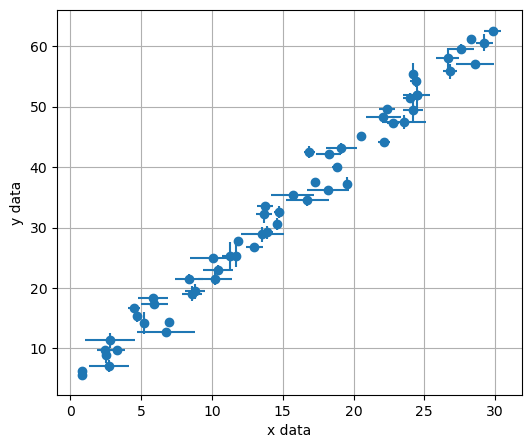

In [3]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.errorbar(x,y,xerr,yerr,fmt='o',ls='None')

ax.set_xlabel('x data')
ax.set_ylabel('y data')
ax.grid(True)

## 4. Bayesian Linear Regression
Major steps for Bayesian linear regression include defining a likelihood function, getting priors and posterior and using these, running the Metroplois Hasting algorithm.

### The probabilistic model

In order use MCMC to perform posterior inference on a model and dataset, we need a function that computes the value of the posterior probability given a proposed setting of the parameters of the model. 
In a linear regression, the model used for fitting x and y dataset is given by 
$$\mathbf{y} = \mathbf{m}\mathbf{x}+\mathbf{b}+\mathbf{\epsilon}$$
where $\mathbf{m}$ is the slope, $\mathbf{b}$ is the intercept and $\mathbf{\epsilon}$ is the intrinsic error. This means that we will be fitting 3 parameters namely slope, intercept and the intrinsic scatter.
The posterior probability for parameters $\mathbf{w} = (m,\,b,\,\epsilon)$ conditioned on a dataset $\mathbf{y}$ is given by

$$p(\mathbf{w} \,|\, \mathbf{y}) = \frac{p(\mathbf{y} \,|\, \mathbf{w}) \, p(\mathbf{w})}{p(\mathbf{y})}$$

where $p(\mathbf{y} \,|\, \mathbf{w})$ is the *likelihood* and $p(\mathbf{w})$ is the *prior*. For this example, we're modeling the likelihood by assuming that the data points are independent with known total uncertainties $\sigma_{tot}$. This specifies a likelihood function:

$$p(\mathbf{y} \,|\, \mathbf{w}) = \prod_{n=1}^N \frac{1}{\sqrt{2\,\pi\,\sigma_{tot}^2}} \,
\exp \left(-\frac{[y_n - f_\mathbf{w}(x_n)]^2}{2\,\sigma_{tot}^2}\right)$$

where $f_\mathbf{w}(x) = m\,x + b$ is the linear model. The total uncertainties $\sigma_{tot}$ is given by $\sqrt{\sigma_y^2 + (m*\sigma_x)^2 + \epsilon^2}$   ($\sigma_y$ and $\sigma_x$ are the errors on y and x dataset respectively).

For numerical reasons, we will actually want to compute the logarithm of the likelihood. In this case, this becomes:

$$\ln p(\mathbf{y} \,|\, \mathbf{w}) = -\frac{1}{2}\sum_{n=1}^N \left(\frac{[y_n - f_\mathbf{w}(x_n)]^2}{\sigma_{tot}^2} + \ln(2\pi\sigma_{tot}^2)\right) \quad.$$

#### Log Likelihood
The following cell has the function to calculate the log likelihood. The function takes initial values of 3 parameters to fit along with the data as input and it should return the log likelihood (a single number) up to a constant. 

In [4]:
def ln_likelihood(param, x, y, xerr, yerr):
    """Functon to setup the log likelihoods 

    Args:
        param (float array eg. np.array((0.0, 0.0, 0.0))): initial values of the 3 parameters
        x (array): x data
        y (array): y data
        xerr (array): error in x
        yerr (array): error in y

    Returns:
        float: likelihood function in log
    """
    m,c, sig_int = param[0], param[1], param[2]
    f = m*x + c
    sigma = np.sqrt((yerr**2) + np.square(m * xerr)+ (sig_int**2))
    
    return -0.5 * np.sum((((y-f) / sigma) ** 2)+ np.log(2*np.pi*(sigma**2)))

In [5]:
# test the ln_likelihood function
ln_likelihood((1, 2, 0.1), x, y, xerr, yerr)

-16690.971803736556

#### Priors and Posterior
For the priors, we'll assume broad uniform priors on $m$, $b$ and $\epsilon$. For $m$ and $b$, values ranging from -10 to 10 is chosen but for $\epsilon$, only positive values must be chosen as this parameter can not be negative. If not done so, the code does not converge as the value oscillates between its positive and negative value.

Remember to change the prior values accordingly if you are using different data.

The function `ln_prior` will return `-np.inf` from `ln_likelihood` when the parameter is outside of the allowed range and will return `0.0` (an arbitrary constant) when the parameters are valid.

Finally, the function `ln_posterior` sums the output of `ln_prior` and `ln_likelihood` to compute the log-posterior probability up to a constant.

In [6]:
def ln_prior(param):
    """Function for setting up the log priors

    Args:
        param (float array): initial values of the 3 parameters

    Returns:
        float: returns a 0.0 or negative infinity depending on the prior range
    """
    m,b,sig_int = param[0], param[1], param[2]
    if not (-10 < m < 10):
        return -np.inf
    if not (-10 < b < 10):
        return -np.inf
    if not (0 < sig_int < 10):
        return -np.inf
    return 0.0

def ln_posterior(theta, x, y, xerr, yerr):
    """Function to setup the log posterior

    Returns:
        float: value of posterior in log
    """
    return ln_prior(theta) + ln_likelihood(theta, x, y, xerr, yerr)

In [7]:
# test the ln_posterior function
ln_posterior((1, 2, 0.1), x, y, xerr, yerr)

# You should get the same value as the ln_likelihood function since parameters are within the prior range.
# Try changing the parameters to (12, 15, -1) to see what happens.

-16690.971803736556

### Metropolis(–Hastings) MCMC

The simplest MCMC algorithm is generally referred to as the Metropolis method. All MCMC algorithms work by specifying a "step" that moves from one position in parameter space to another with some probability. The Metropolis step takes a position $\theta_t$ (a vector containing the slope, intercept and intrinsic scatter at step $t$) to the position $\theta_{t+1}$ using the following steps:

1. propose a new position $\mathbf{q}$ drawn from a Gaussian centered on the current position $\theta_t$
2. compute the probability of the new position $p(\mathbf{q}\,|\,\mathbf{y})$
3. draw a random number $r$ between 0 and 1 and if
$$r < \frac{p(\mathbf{q}\,|\,\mathbf{y})}{p(\mathbf{x}_t\,|\,\mathbf{y})}$$
return $\mathbf{q}$ as $\theta_{t+1}$ and, otherwise, return $\theta_t$ as $\theta_{t+1}$.

The following cell contains the function for this metropolis step. The function takes 5 arguments:

1. x and y dataset along with errors.
2. the current position $\theta_t$,
3. the ln-probability at the current point $p(\theta_t\,|\,\mathbf{y})$, and
4. the covariance matrix of the Gaussian proposal distribution. (A diagonal matrix that determines the step size in each parameter direction.)

It returns two values, the new coordinate $\theta_{t+1}$ and the ln-probability at that point $p(\theta_{t+1}\,|\,\mathbf{y})$.

In [8]:
def metropolis_step(x, y, xerr, yerr, ln_post_0, theta_0, step_cov):
    """Function that takes a step in the mcmc chain using the metropolis hastings algorithm

    Args:
        x (array): x data
        y (array): y data
        xerr (array): error in x
        yerr (array): error in y
        ln_post_0 (float): initial value of the log posterior
        theta_0 (float, array): initial values of the parameters (used as mean for the random multivariate draw). Defaults to np.array((0.0, 0.0, 0.0)).
        step_cov (float, array): diagonal matrix used to control the step size for mcmc. Defaults to np.diag((1e-3, 1e-4, 1e-4)).

    Returns:
        (array, float): (parameters values, its log posterior)
    """
    q = np.random.multivariate_normal(theta_0, step_cov)
    ln_post = ln_posterior(q, x, y, xerr, yerr)
    if ln_post - ln_post_0 > np.log(np.random.rand()):
        return q, ln_post
    return theta_0, ln_post_0

In [9]:
# test the metropolis_step function. 
# Sometimes you will get the same value of the parameters and sometimes you will get a new value.
metropolis_step(x, y, xerr, yerr, ln_posterior((0.0, 0.0, 1.0), x, y, xerr, yerr), 
                theta_0 = np.array((0.0, 0.0, 1.0)), step_cov=np.diag((1e-3, 1e-4, 1e-4)))

(array([ 0.05755251, -0.00782957,  1.00270109]), -27079.24063066031)

### Running the Markov Chain

Now that we have an implementation of the Metropolis step, we can go on to sample from the posterior probability density that we implemented above. To start, we need to initialize the sampler somewhere in parameter space. Here (0.0, 0.0, 1.0) are chosen as the initial values for the slope, intercept and intrinsic scatter.

In the next cell, we'll start from this initial guess for the 3 parameters and walk through parameter space (using the transition probability from above) to generate a Markov Chain of samples from the posterior probability.

#### Tuning parameters: 
There are a few tuning parameters for this method that one can change to improve the performance of the sampler.
1. The first and most important is the **initialization**. The practical performance of an MCMC sampler depends sensitively on the initial position. Try to not give the initial values very far from the true values. If you do so, the sampler will take a long time to converge.

2. The second big tuning parameter is **the scale of the proposal distribution**. We must specify the covariance matrix for the proposal Gaussian. This is refers to the step size in Metropolis Hasting algorithm. In 1 dimension, the step size is determined by a random draw from a normal distribution centered around the previous value. If the standard deviation is larger, larger steps will be taken and vice versa. In 3 dimension, a 3x3 diagonal matrix is required to determine this step size.
To check if the step size is correct, you can check the acceptance fraction (the fraction of accepted proposals). For low dimension problems the target is around about 50% but for harder problems in higher dimensions, a good target is around 20%. Another useful diagnostic is a plot of the parameter values as a function of step number. For example, if this looks like a random walk then your proposal scale is probably too small. Once you reach a good proposal, this plot should "look converged".

3. Third tuning parameter is **the number of steps to take**. In theory, you need to take an infinite number of steps but that is not realistic.  So instead select a large enough number of samples so that the sampler has sufficiently explored parameter space and converged to a stationary distribution. 
You can also change the number of steps that are discarded as **burn-in** (approximately initial 10% points) The burn-in is discarded because the sampler has not yet converged to the stationary distribution 

The following function runs the MCMC chain for a given number of steps and returns the Markov chain of samples from the posterior probability distribution.

In [10]:
def MCMC(x, y, xerr, yerr, theta_0, step_cov, n_steps):
    """Function that runs the mcmc chain

    Args:
        x (array): x data
        y (array): y data
        xerr (array): error in x
        yerr (array): error in y
        theta_0 (float, array): initial values of the parameters (used as mean for the random multivariate draw). Defaults to np.array((0.0, 0.0, 0.0)).
        step_cov (float, array): diagonal matrix used to control the step size for mcmc. Defaults to np.diag((1e-3, 1e-4, 1e-4)).
        n_steps (int): Number of mcmc samples. Defaults to 20000.

    Returns:
        3 dimensional numpy array: chain of mcmc samples
    """
    lp0 = ln_posterior(theta_0, x, y, xerr, yerr)
    chain = np.empty((n_steps, len(theta_0)))
    for i in range(len(chain)):
        theta_0, lp0 = metropolis_step(x, y, xerr, yerr, lp0, theta_0, step_cov)
        chain[i] = theta_0
    return chain

In [11]:
# test the MCMC function by chaning the following parameters
initial_values = np.array((0.0, 0.0, 1))
step_size_cov = np.diag((0.005, 0.5, 0.05))
number_of_steps = 50000
burn_in = 5000

chain = MCMC(x, y, xerr, yerr, theta_0=initial_values, step_cov=step_size_cov, n_steps=number_of_steps)

Plot the chain results to see if the sampler has converged. If it has not converged, try changing the tuning parameters and rerunning the sampler.

The acceptance fraction was: 0.194


Text(0.5, 1.0, 'acceptance: 0.194')

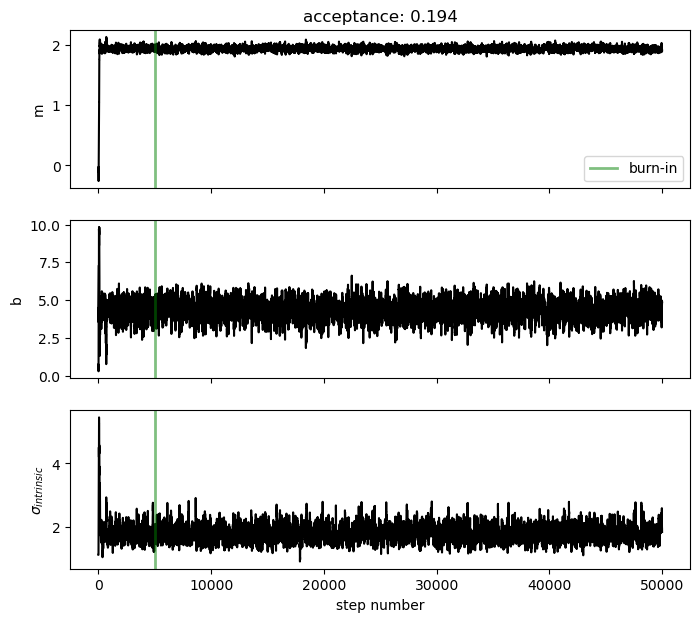

In [12]:
# Compute the acceptance fraction.
acc = float(np.any(np.diff(chain, axis=0), axis=1).sum()) / (len(chain)-1)
print("The acceptance fraction was: {0:.3f}".format(acc))

# Plot the traces.
fig, axes = plt.subplots(3, 1, figsize=(8, 7), sharex=True)
axes[0].plot(chain[:, 0], "k")
axes[0].set_ylabel("m")
axes[0].axvline(burn_in, color="g", alpha=0.5, lw=2, label="burn-in")
axes[0].legend()

axes[1].plot(chain[:, 1], "k")
axes[1].set_ylabel("b")
axes[1].axvline(burn_in, color="g", alpha=0.5, lw=2)

axes[2].plot(chain[:, 2], "k")
axes[2].set_ylabel("$\sigma_{intrinsic}$")
axes[2].axvline(burn_in, color="g", alpha=0.5, lw=2)

axes[2].set_xlabel("step number")
axes[0].set_title("acceptance: {0:.3f}".format(acc))

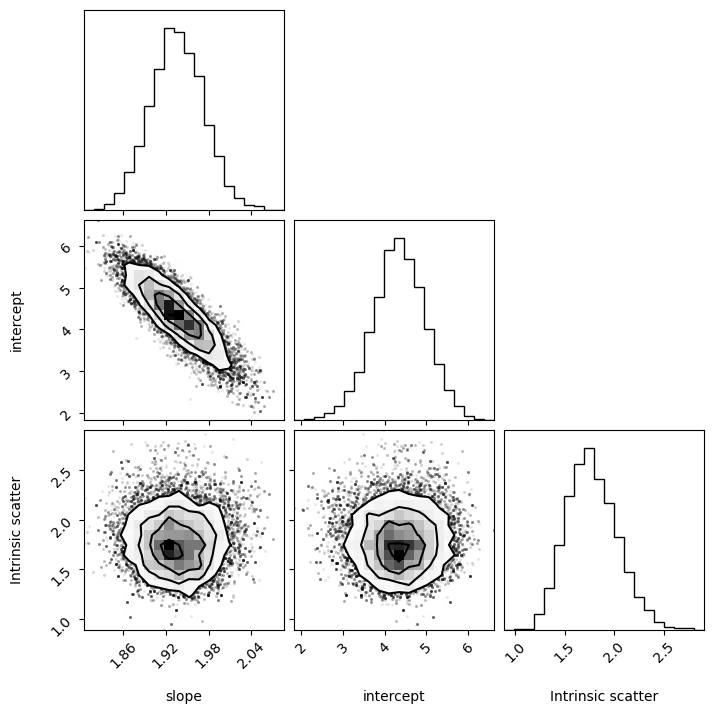

In [13]:
# making a corner plot to see the 1D and 2D distributions of the parameters
import corner
figure = corner.corner(chain[burn_in:], labels=["slope", "intercept", "Intrinsic scatter"])

In [14]:
print("The best fit parameters are:")
print("m = {0:.3f} +/- {1:.3f}".format(np.mean(chain[burn_in:,0]), np.std(chain[burn_in:,0])))
print("b = {0:.3f} +/- {1:.3f}".format(np.mean(chain[burn_in:,1]), np.std(chain[burn_in:,1])))
print("sigma_int = {0:.3f} +/- {1:.3f}".format(np.mean(chain[burn_in:,2]), np.std(chain[burn_in:,2])))

The best fit parameters are:
m = 1.936 +/- 0.037
b = 4.344 +/- 0.631
sigma_int = 1.778 +/- 0.256


#### Plotting the best fit line

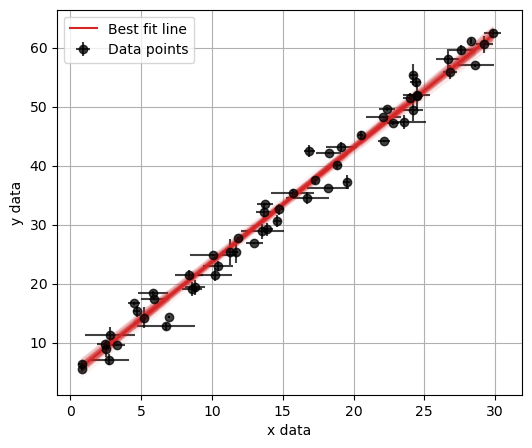

In [15]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.errorbar(x,y,xerr,yerr,fmt='o',ls='None', color='k', alpha=0.75, label='Data points')

ax.plot(x, np.mean(chain[burn_in:,0])*x + np.mean(chain[burn_in:,1]), "tab:red", label='Best fit line')
for m, b, int_scat in chain[burn_in+np.random.randint(len(chain)-burn_in, size=100)]:
    ax.plot(x, m*x + b, "tab:red", alpha=0.05)
    
ax.legend()    
ax.set_xlabel('x data')
ax.set_ylabel('y data')
ax.grid(True)    

#### Flowchart
Here is the flowchart for the code that is written so far. This will help you understand the code better. 

![Flowchart](Images/flowchart.png)

## 5. Fast Bayesian Linear Regression

Running the MCMC algorithm can be computationally expensive. This is because the algorithm requires a large number of iterations to converge to the stationary distribution. In this section, we will discuss techniques for speeding up the inference process.

Use the following cell to run the MCMC algorithm and time how long it takes to run.

In [16]:
# import the library to calculate the time taken to run the code
import time
time_taken = %timeit -o _ = MCMC(x, y, xerr, yerr, theta_0=initial_values, step_cov=step_size_cov, n_steps=number_of_steps)

7.89 s ± 180 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numba

Numba is a just-in-time compiler for Python that works best on code that uses NumPy arrays and functions, and loops. It is a tool that helps in making the cutting down the processing time and makes the code faster for multiple use.
Have a look at the file [FBR.py](https://github.com/AdiPandya/Fast_Bayesian_Regression/blob/main/FBR.py) to see how the code has been modified to make it faster.
The only major change is the addition of the `@njit` decorator to the all the functions. This decorator tells Numba to compile the function using the LLVM compiler and to generate optimized machine code for the function.

#### Important Note: 
Not all numpy functions are supported by Numba. For a list of supported functions, see [here](https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html). Refer to Appendix A.1 for more details.

To use the contents of the file [FBR.py](https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html), import the file as a module using the following command:

In [17]:
import FBR

In [19]:
%time _ = FBR.MCMC(x, y, xerr, yerr, theta_0=initial_values, step_cov=step_size_cov, n_steps=number_of_steps)

CPU times: total: 78.1 ms
Wall time: 75.1 ms


The first time you run the code, Numba will compile the functions and cache the compiled machine code. This means that the first time you run the code, it will take a little longer to run. However, subsequent runs will be much faster.

In [21]:
new_time = %timeit -o _ = FBR.MCMC(x, y, xerr, yerr, theta_0=initial_values, step_cov=step_size_cov, n_steps=number_of_steps)

118 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


If you just want to get the best fit parameters, you can use the `FBR.get_param` function. This function takes the x and y data along with their errors as input and returns the best fit parameters along with their errors.

In [22]:
slope, slope_err, intercept, intercept_err, intrinsic_scatter, intrinsic_scatter_err = FBR.get_param(x, y, xerr, yerr, theta_0=initial_values, step_cov=step_size_cov, n_steps=number_of_steps, burn_in=burn_in)
print("The best fit parameters are:")
print("m = {0:.3f} +/- {1:.3f}".format(slope, slope_err))
print("b = {0:.3f} +/- {1:.3f}".format(intercept, intercept_err))
print("intrinsic scatter = {0:.3f} +/- {1:.3f}".format(intrinsic_scatter, intrinsic_scatter_err))

The best fit parameters are:
m = 1.939 +/- 0.038
b = 4.302 +/- 0.660
intrinsic scatter = 1.806 +/- 0.266


# 6. Comparision with and without Numba

In [23]:
improvement = time_taken.average/new_time.average
print("The code is {0:.2f} times faster!!".format(improvement))

The code is 66.67 times faster!!


This shows the time taken to run the code with and without Numba. The time taken to run the code with Numba is much less than the time taken to run the code without Numba. This shows that Numba is a very useful tool to make the code faster specially when the code is run multiple times.

# 7. Bonus: How to make your code faster

## Multiprocessing
***Work in progress...***
## Python Profiling
***Work in progress...***

# Appendix A.1: 

## Converting data and errors to log
To fit a power law to your data, you need to convert your data and errors to log space. This way one can fit a straight line to the data.
If you want to fit your data in log space, you can use the following function to convert your data and errors to log space. This function takes the x and y data along with their errors as input and returns the log of x and y data along with their errors.
It is useful to normalize the data by their median value before getting the best fit. This is because the best fit parameters are sensitive to the normalization of the data. If the data is normalized, the intercept will be 0.0. This makes it easier to compare the best fit parameters for different datasets.

In [1]:
def lin_2_log(x_data, y_data, x_errors, y_errors, normalize = True):
    """Function to convert the data from log space to linear space

    Args:
        x_data (array): x data
        y_data (array): y data
        x_errors (array): error in x
        y_errors (array): error in y
        normalize (bool, optional): If True, the data is normalized by median. Defaults to True.

    Returns:
        array: data in linear space
    """
    median_x = np.median(x_data)
    median_y = np.median(y_data)
    
    if normalize:
        x_log = np.log10(x_data/median_x)
        y_log = np.log10(y_data/median_y)
        
    else:
        x_log = np.log10(x_data)
        y_log = np.log10(y_data)
    
    x_err_log = np.log10(np.e)*x_errors/x_data
    y_err_log = np.log10(np.e)*y_errors/y_data
        
        
    return x_log, y_log, x_err_log, y_err_log

## Symmetric Errors
Sometimes the errors in x and y dataset might be asymmetric. This can cause problems when fitting the data. To get around this, just take the average of the upper and lower errors and use that as the error for that data point. This will make the errors symmetric.

## Functions not available in Numba
One of the function not supported by numba is `np.random.multivariate_normal`. This function is used to generate a random number from a multivariate normal distribution. To get around this, here is a new function which does the same thing but is supported by numba.

```python
def multivariate_sample(mean, cov):
    """Function to get a sample from a multivariate normal distribution

    Args:
        mean (float array eg. np.array((0.0, 0.0, 0.0))): mean for the multivariate normal distribution
        cov (float diagonal matrix eg. np.diag((1e-3, 1e-4, 1e-4))): covariance matrix for the multivariate normal distribution

    Returns:
        float array: random sample from the multivariate normal distribution
    """
    return mean + np.linalg.cholesky(cov) @ np.random.standard_normal(mean.size)